<a href="https://colab.research.google.com/github/yhk775206/AIContents/blob/main/c_customLoad_%EC%9D%91%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable

from PIL import Image

In [33]:
# 네트워크에 들어갈 이미지 크기
#  ㄴ네트워크에는 동일한 크기의 이미지만 넣을 수 있음. 
#  ㄴGPU 병렬처리 때문
imgsize = 128  

In [34]:
# 폴더 이름
img_dir =  "drive/MyDrive/my_catdog/train/"  #"./images/"  # "../../images/cats/"

In [35]:
import os

"""
======================================================
MyGetInfoFromFolder
======================================================
* 폴더에서 클래스 관련 정보 추출
 - classes: 클래스 이름(=폴더명)
 - class_to_idx: { (클래스 이름): (인덱스) } 쌍
 - length: 폴더 내 모든 이미지 개수
 - total_file_list: 모든 이미지 파일의 경로 리스트
 - total_label: 모든 이미지의 라벨 리스트

* 양희경 함수- read_2path
"""
def MyGetInfoFromFolder(ipath):
  classes = sorted(os.listdir(ipath))
  class_to_idx = {}
  length = 0
  total_file_list=[]
  total_label=[]

  for i, c in enumerate(classes):  # class 폴더
    class_to_idx.update({c: i})

    file_list = sorted(os.listdir(ipath + "/" + c))
    length += len(file_list)

    for f in file_list:  # 이미지 파일 리스트
      total_file_list.append(ipath + c + "/" +f)
      total_label.append(i)

  return classes, class_to_idx, length, total_file_list, total_label

In [36]:
# MyGetInfoFromFolder 호출 테스트
classes, class_to_idx, length, total_file_list, total_label = MyGetInfoFromFolder(img_dir)
print(classes)
print(class_to_idx)
print(length)
print(total_file_list[0])
print(total_label[0])

['cats', 'dogs']
{'cats': 0, 'dogs': 1}
10
drive/MyDrive/my_catdog/train/cats/images (2).jpeg
0


### CropImgSquare
* 최대한 크게 정사각형으로 자르기

In [37]:
"""
======
CropImgSquare
======
* 최대한 크게 정사각형으로 자르기
* Input: PIL Image 의 img
* Output: cropped img
"""
def CropImgSquare(img):
  # 1. 단축 계산
  small_len = min(img.width, img.height)
  # 2. 중심 계산
  cx, cy = img.width/2, img.height/2
  # 3. 단축의 반 계산
  d = small_len/2

  # 4. Crop
  # PIL Image - crop
  # (left, top, right, bottom)
  (left, top, right, bottom) = (cx-d, cy-d, cx+d, cy+d)
  img = img.crop((left, top, right, bottom))

  return img

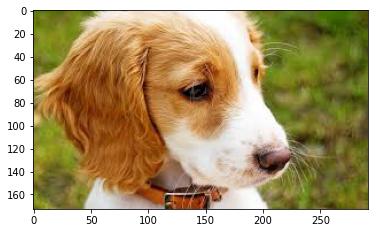

292 173


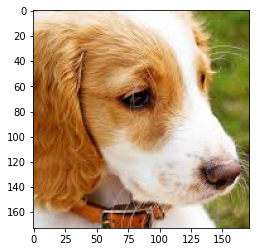

172 173


In [38]:
# CropImg 테스트
# 1. 이미지 오픈
dir = img_dir + "dogs/images (2).jpeg"
img = Image.open(dir)

# 2. 1 시각화
plt.imshow(img)
plt.show()

print(img.width, img.height)

# 3. 자르기
img = CropImgSquare(img)

# 4. 3 시각화
plt.imshow(img)
plt.show()

print(img.width, img.height)

In [79]:
"""
======================================================
MyImageFolder
======================================================
* Custumized dataset
  폴더의 영상을 가져올 수 있는 클래스의 객체
  dset.ImageFolder 역할

* 입력 변수
   ipath: 데이터가 들어있는 경로
   ㄴ예) 'technique' or 'style' or 'artist_slug' or ...   
  imgsize: 기준이 되는 imgsize
    ㄴ주의: rescale의 최대 배수의 사이즈가 네트워크가 안터지는 최대 사이즈 이하여야 함

* 응용
 - 비율 변경 없이 최대한 크게 정사각형으로 자르고, 크기 맞추기(Resize)

* 양희경 클래스- Dataset_folder
"""
class MyImageFolder(Dataset):
  def __init__ (self, ipath,
                transform=transforms.ToTensor()):
    self.classes, self.class_to_idx, self.length, self.flist, self.labels = MyGetInfoFromFolder(ipath)
    
    self.root_dir = ipath    
    self.transform=transform
    
  def __len__(self):
    return self.length  # 이 path 에 있는 모든 폴더의 모든 이미지 개수

  def __getitem__(self, idx):     
    # original image
    img = Image.open(self.flist[idx])

    # 예외처리-mode 
    if (img.mode!="RGB"): 
      img = img.convert(mode="RGB")
    
    img_dist = self.transform(img)  # --- [changed] 강제 resize ---

    img = CropImgSquare(img)

    # 이미지 조정
    img = self.transform(img)

    # label
    label = self.labels[idx]

    #return img  #, label
    return img, label, img_dist  # ---  [changed] 0: img, 1: label, 2: img_dist

In [80]:
# Dataset_folder 호출 테스트
my_train = MyImageFolder(img_dir, 
                          transforms.Compose([transforms.Resize((imgsize, imgsize)),
                                              transforms.ToTensor()]
                                              ))

In [81]:
nclass = len(my_train.classes)
print("# of classes(클래스 개수): %d" %nclass)

print("클래이 이름:", my_train.classes)
print("클래스별 인덱스:", my_train.class_to_idx)
print("my_train 개수:", my_train.__len__())

# of classes(클래스 개수): 2
클래이 이름: ['cats', 'dogs']
클래스별 인덱스: {'cats': 0, 'dogs': 1}
my_train 개수: 10


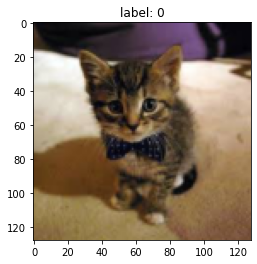

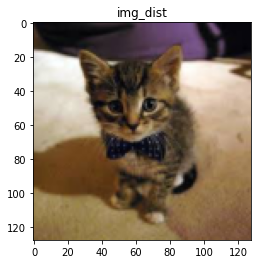

torch.Size([128, 128, 3])


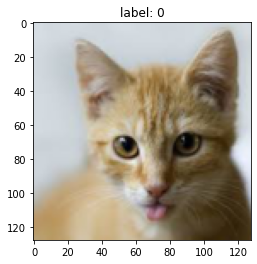

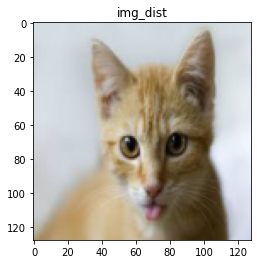

torch.Size([128, 128, 3])


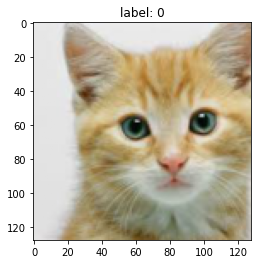

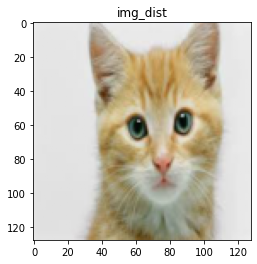

torch.Size([128, 128, 3])


In [82]:
for i in range(3):
  img = my_train[i][0]  #.numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
  img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

  plt.title("label: %d" %my_train[i][1] )
  plt.imshow(img)
  plt.show()

  # --- [changed] 강제 Resize img 시각화
  img = my_train[i][2]  #.numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
  img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

  plt.title("img_dist")
  plt.imshow(img)
  plt.show()

  print(img.shape)  #print(img.size)

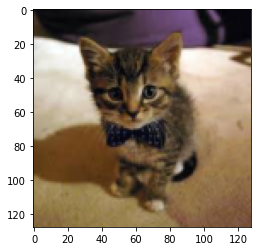

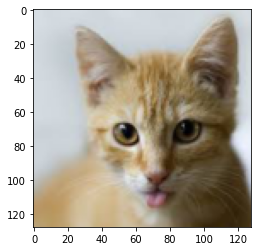

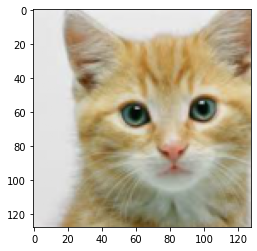

In [76]:
for i in range(3):
  img = my_train[i]  #.numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
  img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

  #plt.title("label: %d" %my_train[i][1] )
  plt.imshow(img)
  plt.show()


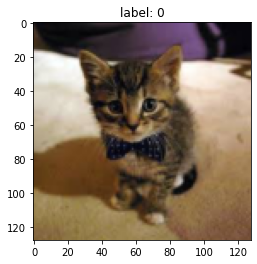

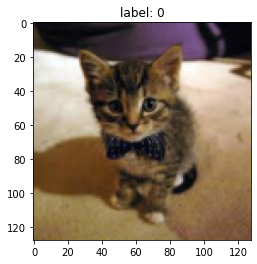

torch.Size([128, 128, 3])


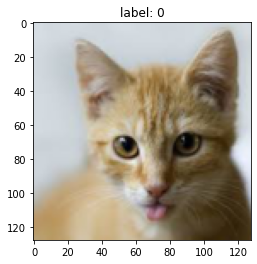

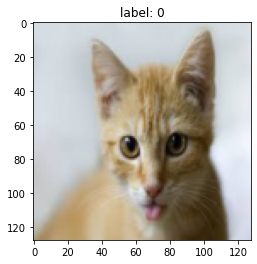

torch.Size([128, 128, 3])


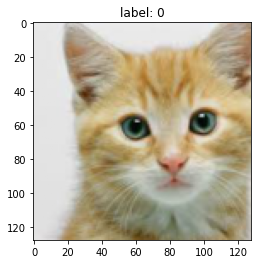

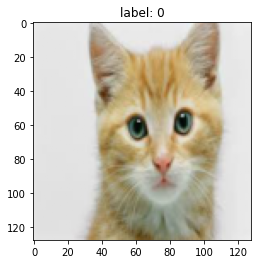

torch.Size([128, 128, 3])


In [68]:
for i in range(3):
  img = my_train[i][0]  #.numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
  img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

  plt.title("label: %d" %my_train[i][1] )
  plt.imshow(img)
  plt.show()

  # # --- 강제 resize 한 것 출력 ---
  # img = my_train[i][2]  #.numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
  # img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)

  # plt.title("label: %d" %my_train[i][1] )
  # plt.imshow(img)
  # plt.show()

  # print(img.shape)  #print(img.size)

In [83]:
batch_size= 3
train_loader = data.DataLoader(my_train, batch_size=batch_size,
                            shuffle=False, num_workers=2,
                            drop_last=True)  # batch_size 만큼 나눌 때 나머지는 버려라

[0]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])


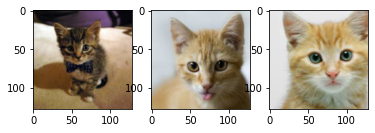

[1]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])


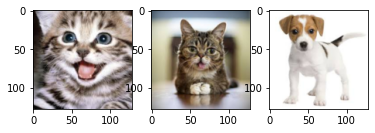

[2]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])


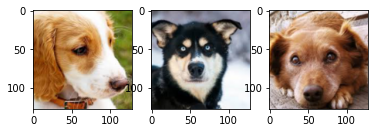

In [78]:
n = 3  # 샘플로 그려볼 데이터 개수
#for i, [imgs, labels] in enumerate(train_loader):  # batch_size 만큼
for i, imgs in enumerate(train_loader):  # batch_size 만큼
    if i>5:
        break
        
    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # GPU 에 로드되기 위함. 만약 CPU로 설정되어 있다면 자동으로(?) CPU로 로드됨
    x = Variable(imgs)#.cuda()     # (batch_size, 3, 28, 28)
    #y_ = Variable(labels)#.cuda()  # (batch_size)
    
    print(x.shape)
    # print(y_.shape)
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
        img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)
        
        plt.subplot(1, n, j+1)  # (1,3) 형태 플랏의 j 번째 자리에 그리겠다
        plt.imshow(img) #, cmap='gray')
        #plt.title("label: %d" %labels[j] )        
    plt.show()

[0]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])
torch.Size([3])


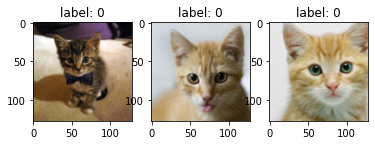

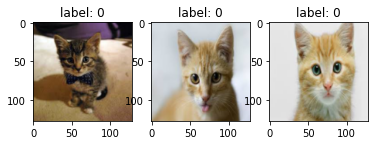

[1]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])
torch.Size([3])


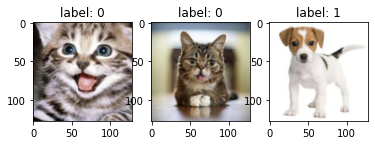

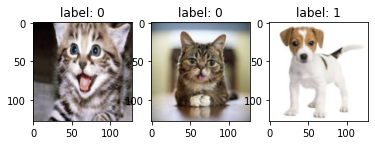

[2]
한 번에 로드되는 데이터 크기: 3
torch.Size([3, 3, 128, 128])
torch.Size([3])


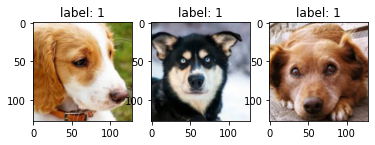

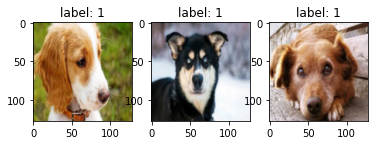

In [70]:
n = 3  # 샘플로 그려볼 데이터 개수
#for i, [imgs, labels] in enumerate(train_loader):  # batch_size 만큼
#for i, imgs in enumerate(train_loader):  # batch_size 만큼
for i, [imgs, labels, img_dists] in enumerate(train_loader):  # batch_size 만큼
    if i>5:
        break
        
    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # GPU 에 로드되기 위함. 만약 CPU로 설정되어 있다면 자동으로(?) CPU로 로드됨
    x = Variable(imgs)#.cuda()     # (batch_size, 3, 28, 28)
    y_ = Variable(labels)#.cuda()  # (batch_size)
    
    print(x.shape)
    print(y_.shape)
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
        img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)
        
        plt.subplot(1, n, j+1)  # (1,3) 형태 플랏의 j 번째 자리에 그리겠다
        plt.imshow(img) #, cmap='gray')
        plt.title("label: %d" %labels[j] )        
    plt.show()
    
    # --- 강제 Resize 이미지도 그리기 ---
    for j in range(n):
        img = img_dists[j].numpy()  # image 타입을 numpy 로 변환 (3, width, height)    
        img = np.transpose(img, (1, 2, 0)) # (3, width, height) -> (width, height, 3)
        
        plt.subplot(1, n, j+1)  # (1,3) 형태 플랏의 j 번째 자리에 그리겠다
        plt.imshow(img) #, cmap='gray')
        plt.title("label: %d" %labels[j] )        
    plt.show()